# 1er Test

✅ Scaler sauvegardé dans model/scaler.save


C:\Users\vicen\miniconda3\envs\projet_finance\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.8175 - loss: 0.0925 - val_accuracy: 0.9029 - val_loss: 0.0627
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9702 - loss: 0.0228 - val_accuracy: 0.9503 - val_loss: 0.0500
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9781 - loss: 0.0206 - val_accuracy: 0.9842 - val_loss: 0.0161
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9811 - loss: 0.0158 - val_accuracy: 0.9842 - val_loss: 0.0139
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9837 - loss: 0.0113 - val_accuracy: 0.9865 - val_loss: 0.0164
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9897 - loss: 0.0103 - val_accuracy: 0.9819 - val_loss: 0.0192
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9903 - loss: 0.0076 - val_accuracy: 0.9865 - val_loss: 0.0151
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9902 - loss: 0.0100 - val_acc

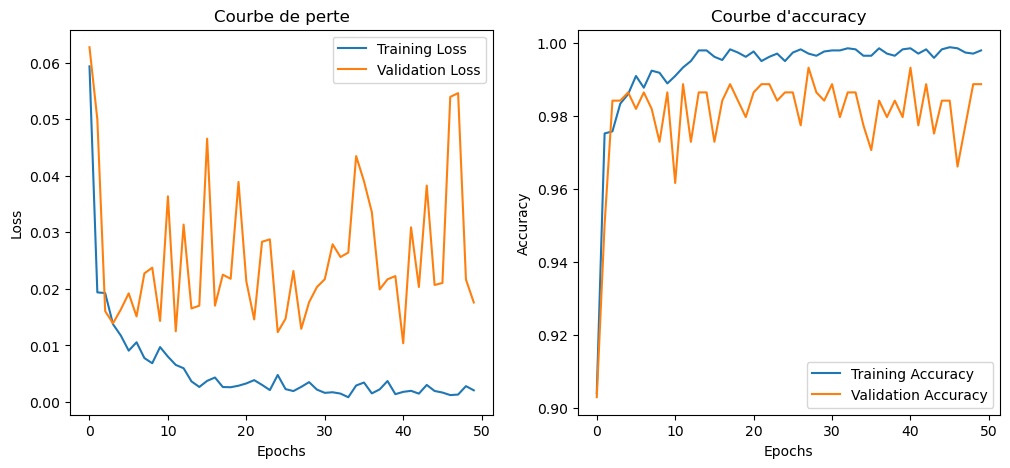

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


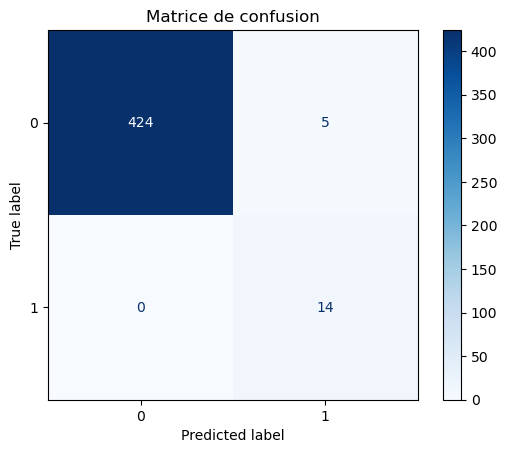

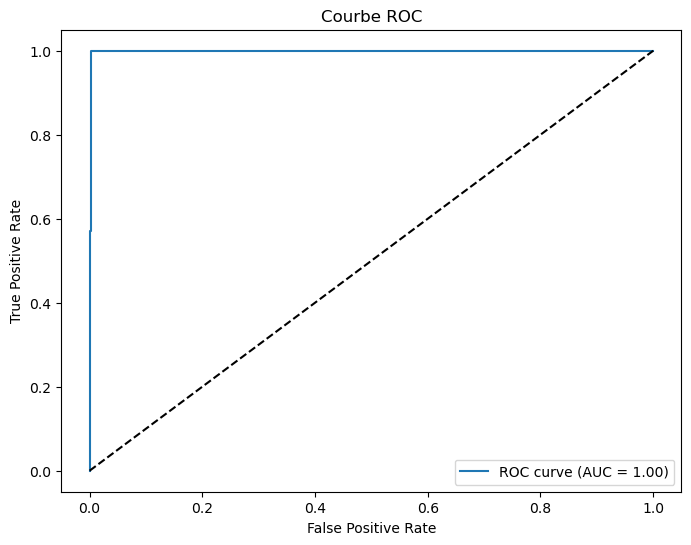

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from hurst import compute_Hc
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import joblib
# Load data
df_clean = pd.read_csv("data\ETH-USD.csv") 
df = df_clean.dropna().copy()

def calculate_volatility(df, window=30):
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100  # Rescaling for GARCH
    df['volatility'] = df['log_return'].rolling(window=window).std() * np.sqrt(365)
    return df

def calculate_garch_volatility(df):
    am = arch_model(df['log_return'].dropna(), vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    df.loc[df.index[1:], 'garch_vol'] = res.conditional_volatility
    return df

def calculate_hurst(df):
    H, _, _ = compute_Hc(df['volatility'].dropna(), kind='price', simplified=True)
    df['hurst'] = H
    return df

def detect_volatility_spikes(df):
    q3 = df['volatility'].quantile(0.75)
    iqr = q3 - df['volatility'].quantile(0.25)
    threshold = q3 + 1.5 * iqr
    df['vol_spike'] = (df['volatility'] > threshold).astype(int)
    return df

df = calculate_volatility(df)
df = calculate_garch_volatility(df)
df = calculate_hurst(df)
df = detect_volatility_spikes(df)



# 🔁 Préparation des données avec scaler retourné
def prepare_lstm_data(df, seq_length=50):
    features = ['volatility', 'garch_vol', 'hurst']
    target = 'vol_spike'
    scaler = RobustScaler()
    df[features] = scaler.fit_transform(df[features])
    
    X, y = [], []
    for i in range(seq_length, len(df)):
        X.append(df[features].iloc[i-seq_length:i].values)
        y.append(df[target].iloc[i])
        
    return np.array(X), np.array(y), scaler

# 📥 Application
X, y, scaler = prepare_lstm_data(df)

# 💾 Sauvegarde du scaler
joblib.dump(scaler, "model/scaler.save")
print("✅ Scaler sauvegardé dans model/scaler.save")

# 🧪 Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🧼 Imputation des NaNs
imputer = SimpleImputer(strategy="median")
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_imputed = imputer.fit_transform(X_train_reshaped)

# 🔁 Reshape pour LSTM
timesteps, features_dim = X.shape[1], X.shape[2]
X_train = X_train_imputed.reshape(X_train.shape[0], timesteps, features_dim)

# ⚖️ Rééquilibrage avec SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(
    X_train.reshape(X_train.shape[0], -1), y_train
)
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], timesteps, features_dim)

# 🧠 Construction du modèle
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(timesteps, features_dim)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryFocalCrossentropy(),
    metrics=['accuracy']
)

# 🏋️ Entraînement du modèle
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

# 💾 Sauvegarde du modèle
model.save("model/lstm_volatility_model.keras")
print("✅ Modèle LSTM sauvegardé dans model/lstm_volatility_model.keras")

# Visualization - Training Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Courbe de perte")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Courbe d'accuracy")
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.58).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend()
plt.show()


# 2nd Test

Données chargées avec succès.


C:\Users\vicen\miniconda3\envs\projet_finance\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.6334 - loss: 0.7183 - val_accuracy: 0.6161 - val_loss: 0.5124
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5326 - loss: 0.6707 - val_accuracy: 0.5816 - val_loss: 0.5188
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4858 - loss: 0.6174 - val_accuracy: 0.4184 - val_loss: 0.6291
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5179 - loss: 0.6366 - val_accuracy: 0.6184 - val_loss: 0.5162
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6584 - loss: 0.5870 - val_accuracy: 0.5494 - val_loss: 0.6137
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5197 - loss: 0.6257 - val_accuracy: 0.6437 - val_loss: 0.5756
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6446 - loss: 0.5433 - val_accuracy: 0.5632 - val_loss: 0.6536
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6553 - loss: 0.5174 - val_accuracy: 0.6828 - 

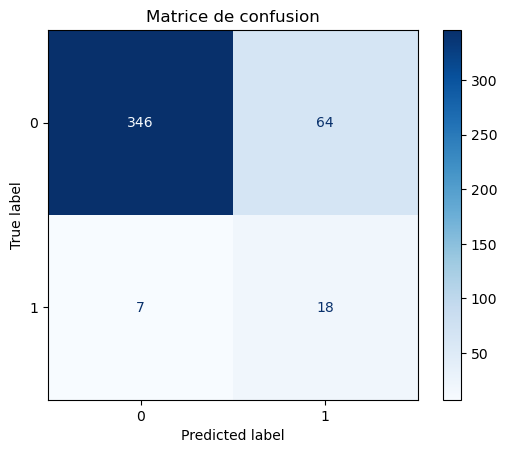

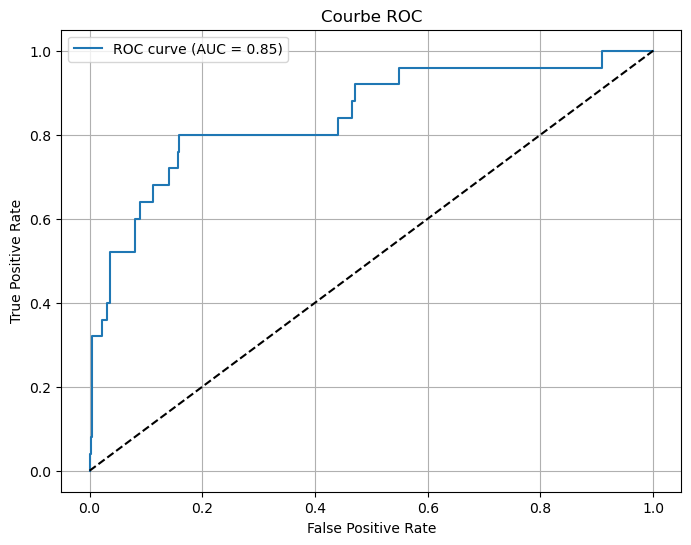

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       410
           1       0.22      0.72      0.34        25

    accuracy                           0.84       435
   macro avg       0.60      0.78      0.62       435
weighted avg       0.94      0.84      0.87       435



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from hurst import compute_Hc
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import BinaryFocalCrossentropy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Chargement des données
try:
    df_clean = pd.read_csv("data/ETH-USD.csv")
    print("Données chargées avec succès.")
except FileNotFoundError:
    raise FileNotFoundError("Fichier 'ETH-USD.csv' introuvable dans le dossier /data.")
    
df = df_clean.dropna().copy()

# Calcul de la volatilité (log return + rolling std)
def calculate_volatility(df, window=30):
    if 'Close' not in df.columns:
        raise ValueError("La colonne 'Close' est absente du DataFrame.")
    
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    if df['log_return'].dropna().shape[0] < window:
        raise ValueError(f"Pas assez de données pour calculer la volatilité avec une fenêtre de {window} jours.")

    df['volatility'] = df['log_return'].rolling(window=window).std() * np.sqrt(365)
    return df

# Volatilité conditionnelle GARCH
def calculate_garch_volatility(df):
    try:
        log_ret = df['log_return'].dropna()
        if len(log_ret) < 60:
            print("Trop peu de données pour le modèle GARCH, fallback sur std(5).")
            df['garch_vol'] = df['log_return'].rolling(5).std()
            return df
        am = arch_model(log_ret, vol='Garch', p=1, q=1)
        res = am.fit(disp='off')
        df.loc[df.index[1:], 'garch_vol'] = res.conditional_volatility
    except Exception as e:
        print(f"Erreur GARCH : {e}. Utilisation du fallback rolling std(5).")
        df['garch_vol'] = df['log_return'].rolling(5).std()
    return df

# Calcul de l'exposant de Hurst
def calculate_hurst(df):
    try:
        vol_series = df['volatility'].dropna()
        if len(vol_series) < 100:
            print("Pas assez de données pour Hurst. Valeur par défaut H = 0.5.")
            df['hurst'] = 0.5
        else:
            H, _, _ = compute_Hc(vol_series, kind='price', simplified=True)
            df['hurst'] = H
    except Exception as e:
        print(f"Erreur lors du calcul de Hurst : {e}. Valeur par défaut H = 0.5.")
        df['hurst'] = 0.5
    return df

# Détection des pics de volatilité
def detect_volatility_spikes(df):
    if 'volatility' not in df.columns:
        raise ValueError("La colonne 'volatility' est absente du DataFrame.")

    rolling_mean = df['volatility'].rolling(20).mean()
    rolling_std = df['volatility'].rolling(20).std()
    threshold = rolling_mean + 2 * rolling_std
    df['vol_spike'] = (df['volatility'] > threshold).astype(int)
    
    return df


df = calculate_volatility(df)
df = calculate_garch_volatility(df)
df = calculate_hurst(df)
df = detect_volatility_spikes(df)


# Préparation des données
def prepare_lstm_data(df, seq_length=90):
    features = ['volatility', 'garch_vol', 'hurst']
    target = 'vol_spike'

    scaler = RobustScaler()
    df[features] = scaler.fit_transform(df[features])

    X, y = [], []
    for i in range(seq_length, len(df)):
        X.append(df[features].iloc[i-seq_length:i].values)
        y.append(df[target].iloc[i])
        
    return np.array(X), np.array(y), scaler

# Pipeline
X, y, scaler = prepare_lstm_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Imputation
imputer = SimpleImputer(strategy="median")
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_imputed = imputer.fit_transform(X_train_reshaped)
timesteps, features_dim = X.shape[1], X.shape[2]
X_train = X_train_imputed.reshape(X_train.shape[0], timesteps, features_dim)

# Poids des classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Modèle LSTM
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(timesteps, features_dim)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

# Sauvegarde
model.save("model/lstm_volatility_balanced.keras")
joblib.dump(scaler, "model/scaler.save")

# Évaluation
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()

# Classification report
print(classification_report(y_test, y_pred_binary, digits=2))


